<a href="https://colab.research.google.com/github/ByeongKyuPark/ByeongKyuPark.github.io/blob/main/CS445_Proj2_Starter_(1)_grok3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

datadir = "/content/drive/MyDrive/Colab Notebooks/CS445 Computational Photography/2_Project_Image_Quilting/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [ ]:
from utils import cut # default cut function for seam finding section

### Utils

In [ ]:
def random_patch(sample, patch_size):
    # extract a random patch from sample of size patch_size x patch_size.
    H, W, C = sample.shape
    i = random.randint(0, H - patch_size)
    j = random.randint(0, W - patch_size)
    return sample[i:i+patch_size, j:j+patch_size]

def ssd_patch(sample, template, mask):
    # SSD between template (from the output) <-> all possible patches in the sample(e.g., texture)
    # SSD = ∑ [ (T•M-S•M) **2] = ∑[ ((T-S)•M) **2] = ∑ (T^2-2TS+S^2)•M
		# 										 = ∑ M•T^2 -2∑(M•T)S + ∑(M•S^2)
		# 										 # M=M^2 for binary M(either 0 or 1)
		# 										 = ∑ (M•T)^2 -2∑(M•T)S + ∑(M•S^2)
		# => ((M*T)**2).sum() - 2*cv2.filter2D(S,kernel = M*T) + cv2.filter2D(S ** 2, kernel=M).

    # for precisions
    template = template.astype(np.float32) # e.g., (3x3)
    sample = sample.astype(np.float32)     # e.g., (5x5)
    mask = mask.astype(np.float32)         # e.g., (3x3)

    s_h, s_w = sample.shape[0], sample.shape[1]
    t_h, t_w = template.shape[0], template.shape[1]

    kernel_h = s_h - t_h + 1 # 5-3+1 = 3
    kernel_w = s_w - t_w + 1 # 5-3+1 = 3

    # 3x3
    ssd_cost = np.zeros((kernel_h, kernel_w), dtype=np.float32)

    # see the comments below
    padding_h, padding_w = (t_h - 1) // 2, (t_w - 1) // 2

    for channel in range(sample.shape[2]):
        M = mask
        T = template[:, :, channel]
        S = sample[:, :, channel]

        # 'cv2.filter2D' internally adds padding for edge computations
        # e.g., for sample[0,0], it pads to include kernel data outside 5x5
        filtered_S = cv2.filter2D(S, -1, M * T)
        filtered_S2 = cv2.filter2D(S ** 2, -1, M)

        # therefore, we trim padded edges to get valid 3x3 cost
        valid_filtered_S = filtered_S[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]
        valid_filtered_S2 = filtered_S2[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]

        ssd_cost += ((M * T) ** 2).sum() - 2 * valid_filtered_S + valid_filtered_S2

    return ssd_cost

def choose_sample(ssd_cost, tol):
    # flatten the cost array
    cols = ssd_cost.shape[1]
    ssd_cost = ssd_cost.flatten()

    # get indices of ascending orders
    sorted_indices = np.argsort(ssd_cost)

    # select one randomly from the top 'tol' cheapest candidates
    selected_index = sorted_indices[random.randint(0, min(tol - 1, len(sorted_indices) - 1))]

    # to 2D again
    return  selected_index // cols , selected_index % cols

### Part I: Randomly Sampled Texture (10 pts)

In [ ]:
def quilt_random(sample, out_size, patch_size): # (192,192,3), 200, 15
    """
    I. Naive Random Patch Quilting
        Randomly picks patches from the sample texture and places them into the output image.
    """
    H, W, C = sample.shape # 192, 192, 3
    print(f'sample size = {H}, {W}, {C}')
    num_patches = int(np.ceil(out_size / patch_size)) # 200/15 = 13.~ -> 14
    print(f'{num_patches} patches') # 14 patches

    # an imaginary canvas for the output (slightly bigger than the output)
    out_canvas_width = num_patches * patch_size # 210
    print(f'{out_canvas_width} output canvas size') # larger than out_size
    out_canvas = np.zeros((out_canvas_width, out_canvas_width, C), dtype=sample.dtype) # 210 X 210

    for i in range(num_patches):
        for j in range(num_patches):
            patch = random_patch(sample, patch_size)
            out_canvas[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    # crop the output image to exactly out_size x out_size.
    print(f'output canvas (before clamping) : {out_canvas.shape}') # larger than out_size
    # clamp the canvas to fit into the out size
    return out_canvas[:out_size, :out_size, :]


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 45
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    # better precision
    sample = np.array(sample, dtype=np.float32)

    # e.g., 200x200x3 zeros for toast output
    result = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    # e.g., 70 - 25 = 45 stride for 70x70 patches, 25 overlap
    stride = patch_size - overlap

    # number of patches to cover the output
    # e.g., ((200 - 1) // 45) + 1 = 5 patches each way for 200 output
    patches_x = ((out_size - 1) // stride) + 1
    patches_y = ((out_size - 1) // stride) + 1

    for i in range(patches_y):
        for j in range(patches_x):

            # clamp to boundaries
            # e.g., min(0 * 45, 200 - 70) = 0, min(4 * 45, 200 - 70) = 130
            start_y = min(i * stride, out_size - patch_size)
            start_x = min(j * stride, out_size - patch_size)

            # for the first patch, grab a random chunk
            if i == 0 and j == 0:
                patch = random_patch(sample, patch_size)
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                # boolean for overlaps checks (left or top)
                left_overlap = j > 0
                top_overlap = i > 0

                # mask for overlap zones (1s where patches touch)
                # e.g., 3x3 mask with 1s in left 1 column for 1 overlap
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_overlap:
                    mask[:, :overlap] = 1  # left 25 pixels for toast match
                if top_overlap:
                    mask[:overlap, :] = 1  # top 25 pixels for toast match

                # grab the current output patch (overlap area only)
                # e.g., 3x3 patch from 5x5 output, mask 1s in overlap
                temp = result[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                temp *= mask[..., np.newaxis]

                # find a best patch match (using SSD)
                cost_map = ssd_patch(sample, temp, mask)
                patch_y, patch_x = choose_sample(cost_map, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # e.g., place 3x3 patch at (0,2) in 5x5 output with 1 overlap
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch

    # e.g., clip 200x200 toast to unsigned char (0–255) values
    return np.clip(result, 0, 255).astype(np.uint8)

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  #300 change these parameters as needed (was 300)
patch_size = 70 # 25
overlap = 25 # 11
tol = 15
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    # plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
def debug_visualize_patch(template, selected, ssd_cost, horiz_mask, vert_mask, combo_mask, illustrate_patch):

    fig, axs = plt.subplots(2, 3, figsize=(10, 9))
    fig.suptitle(f"Debugging Quilt-Cut at ({illustrate_patch[0]}, {illustrate_patch[1]})")

    # Template
    axs[0, 0].imshow(template.astype(np.uint8))
    axs[0, 0].set_title("Template - Overlapping Portion")
    # Sample
    axs[0, 1].imshow(selected.astype(np.uint8))
    axs[0, 1].set_title("Sample - Best Patch Found")

    # SSD
    axs[0, 2].imshow(ssd_cost, cmap='magma')
    axs[0, 2].set_title("SSD Cost in Pixels")

    # Masks
    axs[1, 0].imshow(horiz_mask, cmap='gray')
    axs[1, 0].set_title("Mask - Horizontal")
    axs[1, 1].imshow(vert_mask, cmap='gray')
    axs[1, 1].set_title("Mask - Vertical")
    axs[1, 2].imshow(combo_mask, cmap='gray')
    axs[1, 2].set_title("Mask - Final")

    for ax in axs.flat:
        ax.axis('off')
    plt.show()

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol, illustrate_patch=(1, 1)):  # be default, (1,1) for now
    sample = np.array(sample, dtype=np.float32)
    output = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    stride = patch_size - overlap
    patches_x = ((out_size - 1) // stride) + 1
    patches_y = ((out_size - 1) // stride) + 1

    for i in range(patches_y):
        for j in range(patches_x):
            start_y = min(i * stride, out_size - patch_size)
            start_x = min(j * stride, out_size - patch_size)

            if i == 0 and j == 0:
                patch = random_patch(sample, patch_size)
                output[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                left_edge = j > 0
                top_edge = i > 0
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_edge:
                    mask[:, :overlap] = 1
                if top_edge:
                    mask[:overlap, :] = 1

                template = output[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                template *= mask[..., np.newaxis]

                cost_map = ssd_patch(sample, template, mask)
                patch_y, patch_x = choose_sample(cost_map, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                curr_mask = np.ones((patch_size, patch_size), dtype=bool)

                # debug - (1) Template - overlapping portions
                if (i, j) == illustrate_patch:
                    template_patch = output[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                    selected_patch = patch.copy()

                if left_edge:
                    old_left = output[start_y:start_y + patch_size, start_x:start_x + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam = cut(diff_left.T).T
                    curr_mask[:, :overlap] = left_seam

                if top_edge:
                    old_top = output[start_y:start_y + overlap, start_x:start_x + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam = cut(diff_top)
                    curr_mask[:overlap, :] = top_seam

                if left_edge and top_edge:
                    corner_left = left_seam[:overlap, :overlap]
                    corner_top = top_seam[:overlap, :overlap]
                    curr_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)

                # debug
                if (i, j) == illustrate_patch:
                    # (2) SSD cost
                    ssd_cost = diff_left if left_edge else diff_top
                    # (3) MASK
                    #    i. horizonatal
                    horiz_mask = np.zeros((patch_size, patch_size), dtype=bool)
                    if top_edge:
                        horiz_mask[:overlap, :] = top_seam
                    #    ii. vertical
                    vert_mask = np.zeros((patch_size, patch_size), dtype=bool)
                    if left_edge:
                        vert_mask[:, :overlap] = left_seam
                    #    iii. combined mask
                    combined_mask = curr_mask

                    # visualize current process
                    # debug_visualize_patch(template_patch, selected_patch, ssd_cost,
                                                # horiz_mask, vert_mask, combined_mask, illustrate_patch)

                out_patch = output[start_y:start_y + patch_size, start_x:start_x + patch_size]
                output[start_y:start_y + patch_size, start_x:start_x + patch_size] = np.where(curr_mask[..., np.newaxis], patch, out_patch)

    return np.clip(output, 0, 255).astype(np.uint8)

In [ ]:
#sample_img_fn = 'samples/bricks_small.jpg'
sample_img_fn = 'samples/fence.jpg'

sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 550  # 300, change these parameters as needed
patch_size = 95 # 25
overlap = 15   # 11
tol = 3

res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)

if res is not None:
    #plt.figure(figsize=(15,15))
    plt.imshow(res)
    plt.title("Quilted Cut Result")
    plt.show()

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guide_img, alpha):
    # Texture transfer using seam-finding with the provided cut function.
    sample = np.array(sample, dtype=np.float32)
    guide_img = np.array(guide_img, dtype=np.float32)
    out_height, out_width = guide_img.shape[:2]
    result = np.zeros((out_height, out_width, sample.shape[2]), dtype=np.float32)
    stride = patch_size - overlap
    # number of patches needed to cover the face (guidance image)
    # e.g., ((300 - 12) // 9) + 1 = 34 patches each way for 300 output
    patches_y = ((out_height - patch_size) // stride) + 1
    patches_x = ((out_width - patch_size) // stride) + 1
    for i in range(patches_y):
        for j in range(patches_x):
            # e.g., min(0 * 9, 300 - 12) = 0, min(33 * 9, 300 - 12) = 288
            start_y = min(i * stride, out_height - patch_size)
            start_x = min(j * stride, out_width - patch_size)
            if i == 0 and j == 0:
                patch = random_patch(sample, patch_size)
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                left_edge = j > 0
                top_edge = i > 0
                overlap_mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_edge:
                    overlap_mask[:, :overlap] = 1
                if top_edge:
                    overlap_mask[:overlap, :] = 1
                # grab current output patch (overlap area only)
                temp = result[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                temp *= overlap_mask[..., np.newaxis]
                # 1. compute SSD for "toast" overlap match
                overlap_cost = ssd_patch(sample, temp, overlap_mask)
                # 2. compute SSD for "face" guide match
                # grab face guide patch for shape match
                guide_patch = guide_img[start_y:start_y + patch_size, start_x:start_x + patch_size]
                # mask for full guide match (all 1s)
                guide_mask = np.ones((patch_size, patch_size), dtype=np.float32)
                guide_cost = ssd_patch(sample, guide_patch, guide_mask)
                # 3. consider both costs
                total_cost = (1 - alpha) * overlap_cost + alpha * guide_cost
                # pick one patch among top N
                patch_y, patch_x = choose_sample(total_cost, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]
                # mask for seam cutting
                full_mask = np.ones((patch_size, patch_size), dtype=bool)
                if left_edge:
                    old_left = result[start_y:start_y + patch_size, start_x:start_x + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam = cut(diff_left.T).T
                    full_mask[:, :overlap] = left_seam
                if top_edge:
                    old_top = result[start_y:start_y + overlap, start_x:start_x + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam = cut(diff_top)
                    full_mask[:overlap, :] = top_seam
                # for both cuts
                if left_edge and top_edge:
                    corner_left = left_seam[:overlap, :overlap]
                    corner_top = top_seam[:overlap, :overlap]
                    full_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)
                # blend patch into output using 'seam mask'
                out_patch = result[start_y:start_y + patch_size, start_x:start_x + patch_size]
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)
    # clamps
    return np.clip(result, 0, 255).astype(np.uint8)

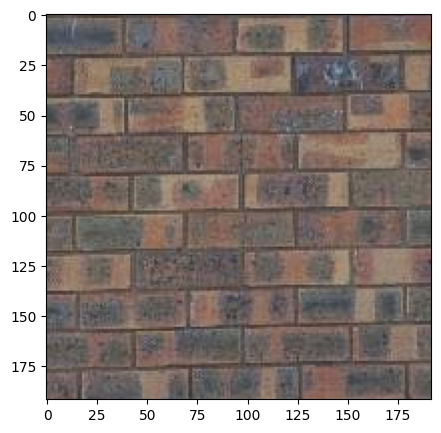

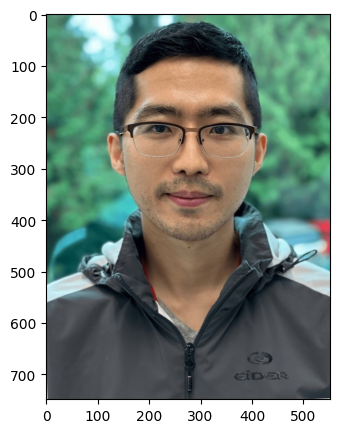

In [ ]:
#texture_img = cv2.cvtColor(cv2.imread('samples/sketch.tiff'), cv2.COLOR_BGR2RGB)
texture_img = cv2.cvtColor(cv2.imread('samples/bricks_small.jpg'), cv2.COLOR_BGR2RGB)
#guidance_img = cv2.cvtColor(cv2.imread('samples/feynman.tiff'), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread('samples/selfie-min.jpg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(texture_img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(guidance_img)
plt.show()

# load/process appropriate input texture and guidance images

patch_size =12
overlap = 3
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(5,5))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [ ]:
def iterative_texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha, num_iters):
    """
    Chill texture loop: refines toast-face blend over multiple rounds for smoothness.
    Uses random starts, SSD picks, and seam cuts, no rough edges.
    """
    # first round is the same basic texture transfering
    result = texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha)

    # gonna refine over and over
    for _ in range(1, num_iters):
        sample = np.array(sample, dtype=np.float32)
        guidance_im = np.array(guidance_im, dtype=np.float32)

        out_height, out_width = guidance_im.shape[:2]

        stride = patch_size - overlap

        # number of patches required to cover the face
        patches_y = ((out_height - patch_size) // stride) + 1
        patches_x = ((out_width - patch_size) // stride) + 1

        for i in range(patches_y):
            for j in range(patches_x):
                # clamp to boundaires
                start_i = min(i * stride, out_height - patch_size)
                start_j = min(j * stride, out_width - patch_size)

                # check overlaps
                left_overlap = j > 0
                top_overlap = i > 0

                # mask for overlap areas
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_overlap:
                    mask[:, :overlap] = 1
                if top_overlap:
                    mask[:overlap, :] = 1

                # grab current patch for overlap
                template = result[start_i:start_i + patch_size, start_j:start_j + patch_size].copy().astype(np.float32)
                template *= mask[..., np.newaxis]

                # 1. SSD
                overlap_ssd = ssd_patch(sample, template, mask)

                # 2. SSD for the 'face'
                #   grab face guide patch
                guide_patch = guidance_im[start_i:start_i + patch_size, start_j:start_j + patch_size]
                #   mask for full guide match
                guide_mask = np.ones((patch_size, patch_size), dtype=np.float32)
                guidance_ssd = ssd_patch(sample, guide_patch, guide_mask)

                # 3. mix costs
                total_cost = (1 - alpha) * overlap_ssd + alpha * guidance_ssd

                # try picking patch with low cost, skip if fails
                try:
                    patch_y, patch_x = choose_sample(total_cost, tol)
                except ValueError as e:
                    print(f"patch pick failed: {e}")
                    continue
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # set up mask for seam cuts
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                if left_overlap:
                    old_left = result[start_i:start_i + patch_size, start_j:start_j + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam_mask = cut(diff_left.T).T
                    full_mask[:, :overlap] = left_seam_mask

                if top_overlap:
                    old_top = result[start_i:start_i + overlap, start_j:start_j + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam_mask = cut(diff_top)
                    full_mask[:overlap, :] = top_seam_mask

                # cut corner overlap (if both exist)
                if left_overlap and top_overlap:
                    full_mask[:overlap, :overlap] = np.logical_and(left_seam_mask[:overlap, :overlap], top_seam_mask[:overlap, :overlap])

                # blend patch with seam mask
                out_patch = result[start_i:start_i + patch_size, start_j:start_j + patch_size]
                result[start_i:start_i + patch_size, start_j:start_j + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

        result = np.clip(result, 0, 255).astype(np.float32)

    return np.clip(result, 0, 255).astype(np.uint8)

In [ ]:
texture_img = cv2.imread('samples/sketch.tiff')
texture_img = cv2.cvtColor(texture_img, cv2.COLOR_BGR2RGB)
guidance_img = cv2.imread('samples/feynman.tiff')
guidance_img = cv2.cvtColor(guidance_img, cv2.COLOR_BGR2RGB)

patch_size = 12#25
overlap = 3#10
tol = 3
alpha = 0.5
num_iters = 3

result_iter = iterative_texture_transfer(texture_img, patch_size, overlap, tol,
                                         guidance_img, alpha,
                                         num_iters=num_iters)

plt.imshow(result_iter)
plt.show()


(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [ ]:
# debug version
def choose_sample(cost, tol):
    # pick a patch spot based on cost, handle weird cases

    flat_cost = cost.flatten()

    valid_indices = np.where(np.isfinite(flat_cost))[0]  # to skip NaNs/infs
    if len(valid_indices) == 0:
        raise ValueError("no valid patches to pick.")

    sorted_indices = valid_indices[np.argsort(flat_cost[valid_indices])]
    max_idx = min(int(tol * len(sorted_indices)), len(sorted_indices) - 1)
    if max_idx < 0:
        raise ValueError("tol too high or no patches.")

    rando_idx = sorted_indices[random.randint(0, max_idx)]
    return rando_idx // cost.shape[1], rando_idx % cost.shape[1]

#--------------------------------------
# [pipeline]
#   create_face_in_toast
#     1. texture_transfer
#     2. create_feathered_mask          - used in laplacian_pyramid_blending (3)
#     3. laplacian_pyramid_blending
#       i. build_gaussian_pyramid
#       ii. build_laplacian_pyramid
#       iii. reconstruct_from_laplacian - rebuild blended final image
#--------------------------------------

# 1. Gaussian Pyramid
def build_gaussian_pyramid(im, max_levels):
    pyramid = [im.astype(np.float32)]
    for _ in range(max_levels - 1):
        im = cv2.pyrDown(im)
        pyramid.append(im.astype(np.float32))
    return pyramid

# 2. Laplacian Pyramid
# builds from the Gaussian pyramid built
def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        upsampled = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=size)
        laplacian = gaussian_pyramid[i] - upsampled
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

# (helper function) for rebuidliing from Laplacian pyramid
# that is, edges -> full image
def reconstruct_from_laplacian(laplacian_pyramid):
    im = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        size = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])
        im = cv2.pyrUp(im, dstsize=size) + laplacian_pyramid[i]
    return im

#  3. blends the toast texture (expressed as a face patch) with the original toast image
def laplacian_pyramid_blending(image_A, image_B, mask, max_levels):
    mask_blur = build_gaussian_pyramid(mask, max_levels)
    blur_A = build_gaussian_pyramid(image_A, max_levels)
    edges_A = build_laplacian_pyramid(blur_A)
    blur_B = build_gaussian_pyramid(image_B, max_levels)
    edges_B = build_laplacian_pyramid(blur_B)

    blended_edges = []
    for i in range(max_levels):
        mask_level = mask_blur[i][..., np.newaxis] if len(mask_blur[i].shape) == 2 else mask_blur[i]
        blended_level = mask_level * edges_B[i] + (1 - mask_level) * edges_A[i]
        blended_edges.append(blended_level)

    blended_img = reconstruct_from_laplacian(blended_edges)
    return np.clip(blended_img, 0, 255).astype(np.uint8)

# 4. make a soft mask for blending
# fade edges for smooth toast-face mix
def create_feathered_mask(shape, x1, y1, x2, y2):
    mask = np.zeros(shape, dtype=np.float32)
    mask[y1:y2, x1:x2] = 1
    mask_bin = (mask * 255).astype(np.uint8)
    dist = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 3)
    max_dist = np.max(dist)
    feathered_mask = dist / max_dist
    return feathered_mask

def create_face_in_toast(toast_path, face_path):
    toast_im = cv2.imread(toast_path)
    face_im = cv2.imread(face_path)

    if toast_im is None or face_im is None:
        raise ValueError("can’t load one or both pics.")
    if toast_im.shape[0] < 20 or toast_im.shape[1] < 20:
        raise ValueError("toast pic too small for 20x20 patches.")

    # hard coded toast spot
    x1, y1 = 63, 40
    #x2, y2 = 241, 198
    x2, y2 = 241, 248

    # 0. resize the face to fit toast spot
    #   e.g., resize 178x157 face to match
    face_resized = cv2.resize(face_im, (x2 - x1, y2 - y1))

    # 1. texture transfer (toast -> face)
    try:
        swapped_patch = texture_transfer(
            sample=toast_im,
            patch_size=7,
            overlap=3,
            tol=0.2,
            guide_img=face_resized,
            alpha=0.7
        )
    except ValueError as e:
        print(f"texture swap failed: {e}")
        return None

    base = toast_im.copy()
    blend = toast_im.copy()
    blend[y1:y2, x1:x2] = swapped_patch

    # 2. make 'soft' mask for smooth edges
    mask = create_feathered_mask(toast_im.shape[:2], x1, y1, x2, y2)

    # 3. blend toast and face (with pyramid)
    face_in_toast_im = laplacian_pyramid_blending(base, blend, mask, max_levels=8)

    cv2.imwrite('face_in_toast.png', face_in_toast_im)
    return face_in_toast_im

In [ ]:
toast_path = 'samples/toast.png'
face_path = 'samples/selfie-min.jpg'
final_toast_face = create_face_in_toast(toast_path, face_path)

if final_toast_face is not None:
    plt.imshow(cv2.cvtColor(final_toast_face, cv2.COLOR_BGR2RGB))
    plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [ ]:
# fill toast holes from outside in, prioritizing edges
# use solidity (known/9x9 patch) and edge strength (max gradient)
# mix scores to pick spots, grab best 9x3 patch within ±50, blend it
#
# loop till holes gone

# 1. CONFIDENCE (ratio of known pixels around the neighborhood)
# count known bits in a patch for holes
def compute_confidence(mask, patch_size):
    """
    Compute confidence term: ratio of known pixels in a patch centered at each pixel.
    """
    # known pixels = 1 / holes = 0
    solidity = np.ones_like(mask, dtype=float)
    solidity[mask == 0] = 0

    patch_half = patch_size // 2
    padded_mask = np.pad(mask, patch_half, mode='constant', constant_values=1)
    solidity_map = np.zeros_like(mask, dtype=float)

    rows, cols = mask.shape
    for r in range(rows):
        for c in range(cols):
            # if hole
            if mask[r, c] == 0:
                patch = padded_mask[r:r + patch_size, c:c + patch_size]
                solidity_map[r, c] = np.sum(patch) / (patch_size ** 2)

    return solidity_map

# find STRONG edges for filling the hole
def compute_edge_strength(image, mask, patch_size):
    """
    Compute edge strength: gradient strength to prioritize structural regions.
    """
    # to grayscale if colorful
    if len(image.shape) == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image

    # i. edge strength
    #   used Sobel filter for numerical gradient computation
    dx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(dx ** 2 + dy ** 2)

    # ii. scale edge strength to [0,1]
    edge_magnitude = edge_magnitude / (np.max(edge_magnitude) + 1e-6)

    # iii. make blank edge 'map' for holes
    edge_map = np.zeros_like(mask, dtype=float)
    half_patch = patch_size // 2
    padded_edges = np.pad(edge_magnitude, half_patch, mode='constant', constant_values=0)

    # scan each hole pixel for strongest edge
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row, col] == 0:  # if a hole
                edge_patch = padded_edges[row:row + patch_size, col:col + patch_size]
                edge_map[row, col] = np.max(edge_patch)  # pick strongest edge

    return edge_map

def get_frontier(mask):
    """
    Identify boundary pixels of the hole (frontier).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(mask, kernel, iterations=1)
    frontier = dilated - mask
    return frontier

# find best patch for the hole
def find_best_patch(image, target_patch, target_mask, patch_size, search_area):
    """
    Find the best matching patch from known regions using SSD.
    """
    # 1. set boundaries
    top, bottom, left, right = search_area
    img_height, img_width = image.shape[:2]
    patch_mid = patch_size // 2

    top = max(0, top - patch_mid)
    bottom = min(img_height - patch_size, bottom + patch_mid)
    left = max(0, left - patch_mid)
    right = min(img_width - patch_size, right + patch_mid)

    # 2. find the closest solid patch(e.g., 9x9) matching with the hole’s edges
    # zero out
    smallest_ssd = float('inf')
    top_patch = None

    # searching
    for r in range(top, bottom):
        for c in range(left, right):
            curr_patch = image[r:r + patch_size, c:c + patch_size]
            curr_mask = mask[r:r + patch_size, c:c + patch_size]  # Assuming global 'mask'

            # patch with "ANY" hole
            if np.any(curr_mask == 0):
                continue

            # calc how similar patches are on solid parts
            difference = target_patch - curr_patch
            solid_pixels = (target_mask == 1)  # extract only 1's from target
            if np.sum(solid_pixels) == 0:  # skip if all 0s
                continue

            # expand dimension for colors
            solid_pixels_3d = np.expand_dims(solid_pixels, axis=2)
            # error term
            ssd = np.sum((difference ** 2) * solid_pixels_3d) / np.sum(solid_pixels)

            # update if better
            if ssd < smallest_ssd:
                smallest_ssd = ssd
                top_patch = curr_patch.copy()

    return top_patch, smallest_ssd

# put a patch onto the hole
def blend_patch(image, patch, row_start, col_start, patch_mask):
    """
    Blend the patch into the image by overwriting hole pixels.
    """
    patch_rows, patch_cols = patch.shape[:2]
    region = image[row_start:row_start + patch_rows, col_start:col_start + patch_cols]
    region[patch_mask == 0] = patch[patch_mask == 0]
    image[row_start:row_start + patch_rows, col_start:col_start + patch_cols] = region

# patch the hole with top picks
def fill_hole(image, mask, patch_size=9):
    """
    Fill arbitrary-shaped holes using patch-based synthesis with priority.
    """
    img_temp = image.copy()
    mask_temp = mask.copy()

    # check patch solidity, spot strong edges
    solidity_score = compute_confidence(mask_temp, patch_size)
    edge_strength = compute_edge_strength(img_temp, mask_temp, patch_size)

    while np.any(mask_temp == 0):
        # find gap edges in toast
        gap_edges = get_frontier(mask_temp)
        if np.sum(gap_edges) == 0:  # no edges left
            break

        # rank spots by solidity and edges
        spot_priority = solidity_score * edge_strength
        spot_priority[gap_edges == 0] = -1  # skip non-edges

        # pick best spot to fix
        row, col = np.unravel_index(np.argmax(spot_priority), spot_priority.shape)

        # set patch area, stay in bounds
        half_patch = patch_size // 2
        r_start = max(row - half_patch, 0)
        r_end = min(row + half_patch + 1, img_temp.shape[0])
        c_start = max(col - half_patch, 0)
        c_end = min(col + half_patch + 1, img_temp.shape[1])

        patch_height = r_end - r_start
        patch_width = c_end - c_start

        target_patch = img_temp[r_start:r_end, c_start:c_end]
        target_mask = mask_temp[r_start:r_end, c_start:c_end]

        # set neighborhood (e.g., +- 50)
        search_zone = (max(0, row - 50), min(img_temp.shape[0], row + 50),
                       max(0, col - 50), min(img_temp.shape[1], col + 50))

        # best patch in the neighborhood
        best_patch, best_ssd = find_best_patch(img_temp, target_patch, target_mask, patch_height, search_zone)

        if best_patch is None:
            continue

        # put and blend
        blend_patch(img_temp, best_patch, r_start, c_start, target_mask)

        # update gap map, reset edge scores
        mask_temp[r_start:r_end, c_start:c_end][target_mask == 0] = 1
        solidity_score[r_start:r_end, c_start:c_end] = 1.0
        edge_strength = compute_edge_strength(img_temp, mask_temp, patch_size)

    return img_temp

In [ ]:
# Load the image
#image = cv2.imread('samples/hole.jfif')
image = cv2.imread('samples/cooling_tower.jpg')
if image is None:
    print("error, was not able to load the image.")
    exit()

h, w = image.shape[:2]
mask = np.ones((h, w), dtype=np.uint8)
#cv2.circle(mask, (128, 73), 39, 0, -1)  # circular base
cv2.circle(mask, (260, 166), 76, 0, -1)  # circular base

# fill the hole
patch_size = 10
filled_image = fill_hole(image, mask, patch_size=patch_size)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original (with hole)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
plt.title("Hole Filled")
plt.axis('off')

plt.show()
cv2.imwrite('filled_tree.png', filled_image)